In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from warnings import simplefilter
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from pathlib import Path

In [65]:
%config InlineBackend.figure_format = 'retina'
simplefilter("ignore")
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

In [34]:
covid = pd.read_csv(r'C:\Users\Lenovo\Downloads\us-counties.csv')
covid

,date,geoid,county,state,cases,cases_avg,cases_avg_per_100k,deaths,deaths_avg,deaths_avg_per_100k
0,2020-01-21,USA-53061,Snohomish,Washington,1,0.14,0.02,0,0.00,0.00
1,2020-01-22,USA-53061,Snohomish,Washington,0,0.14,0.02,0,0.00,0.00
2,2020-01-23,USA-53061,Snohomish,Washington,0,0.14,0.02,0,0.00,0.00
3,2020-01-24,USA-53061,Snohomish,Washington,0,0.14,0.02,0,0.00,0.00
4,2020-01-24,USA-17031,Cook,Illinois,1,0.14,0.00,0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...
1774199,2021-09-29,USA-69120,Tinian,Northern Mariana Islands,0,0.00,0.00,0,0.00,0.00
1774200,2021-09-29,USA-69110,Saipan,Northern Mariana Islands,0,0.43,0.89,0,0.00,0.00
1774201,2021-09-29,USA-78030,St. Thomas,Virgin Islands,7,5.00,9.68,1,0.14,0.28
1774202,2021-09-29,USA-78020,St. John,Virgin Islands,0,0.86,20.55,0,0.00,0.00


In [35]:
covid["date"] = pd.to_datetime(covid["date"])
covid = covid.set_index('date').to_period('D')

In [36]:
covid.drop(columns=['geoid','county', 'state', 'cases', 'cases_avg', 'deaths', 'deaths_avg', 'deaths_avg_per_100k'],axis=1,inplace=True)

In [60]:
average_cases = covid.groupby('date').mean()['cases_avg_per_100k']

In [38]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


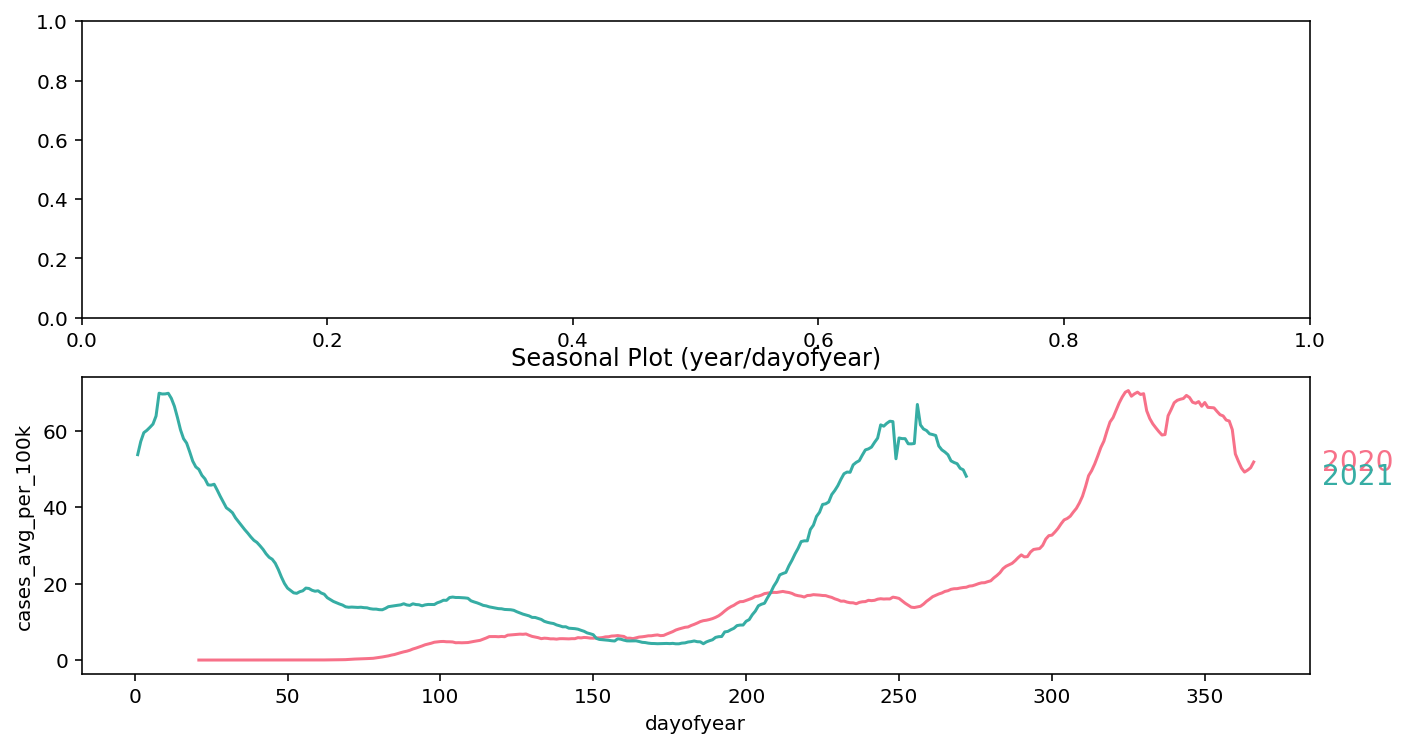

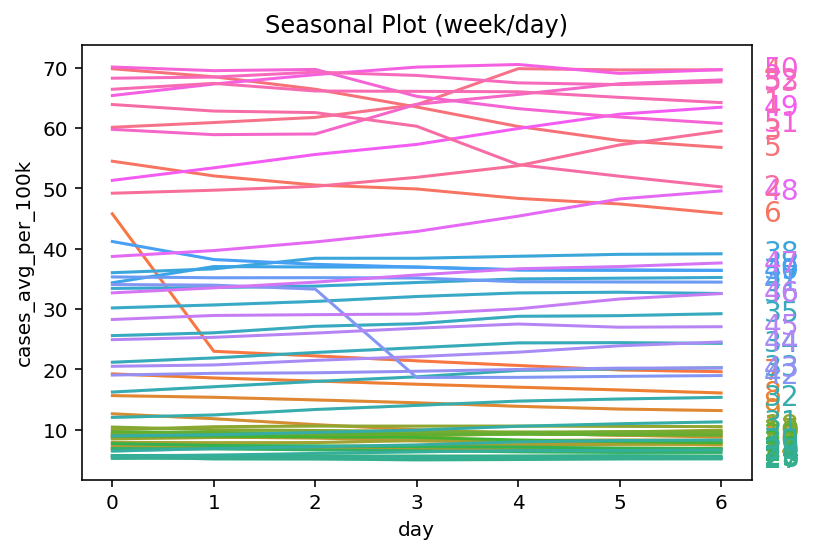

In [39]:
X = average_сases.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y='cases_avg_per_100k', period='week', freq='day');
seasonal_plot(X, y="cases_avg_per_100k", period="year", freq="dayofyear", ax=ax1);

In [40]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


In [54]:
covid = covid.fillna(0)

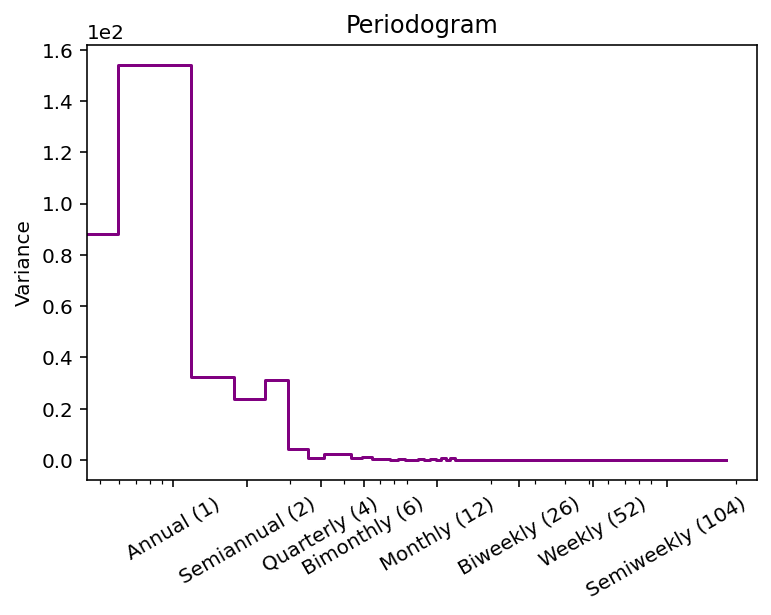

In [62]:
plot_periodogram(average_cases);

In [63]:
y = average_cases.copy()
fourier = CalendarFourier(freq="M", order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,             
    seasonal=True,               
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample() 

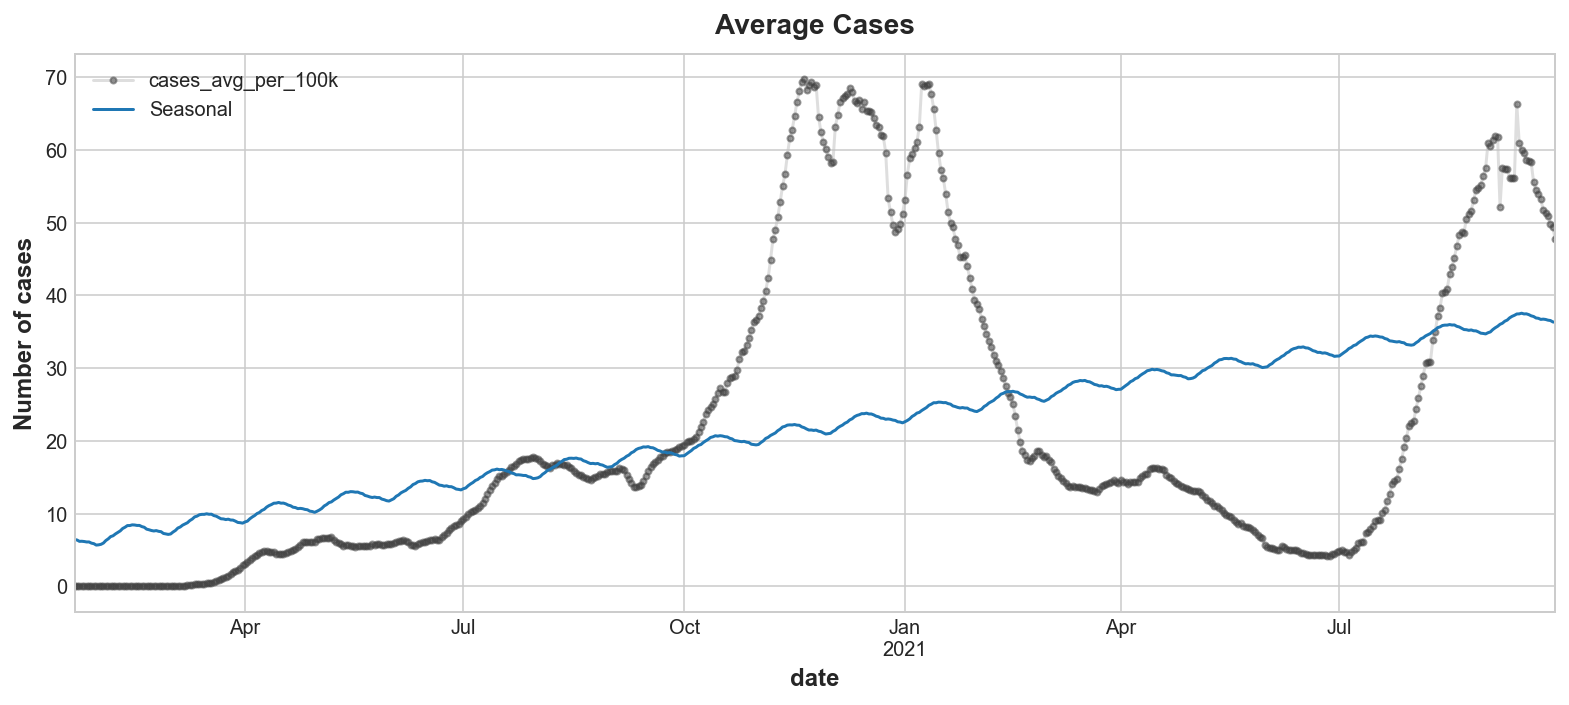

In [66]:
model = LinearRegression().fit(X, y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X), index=X.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Cases", ylabel="Number of cases")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

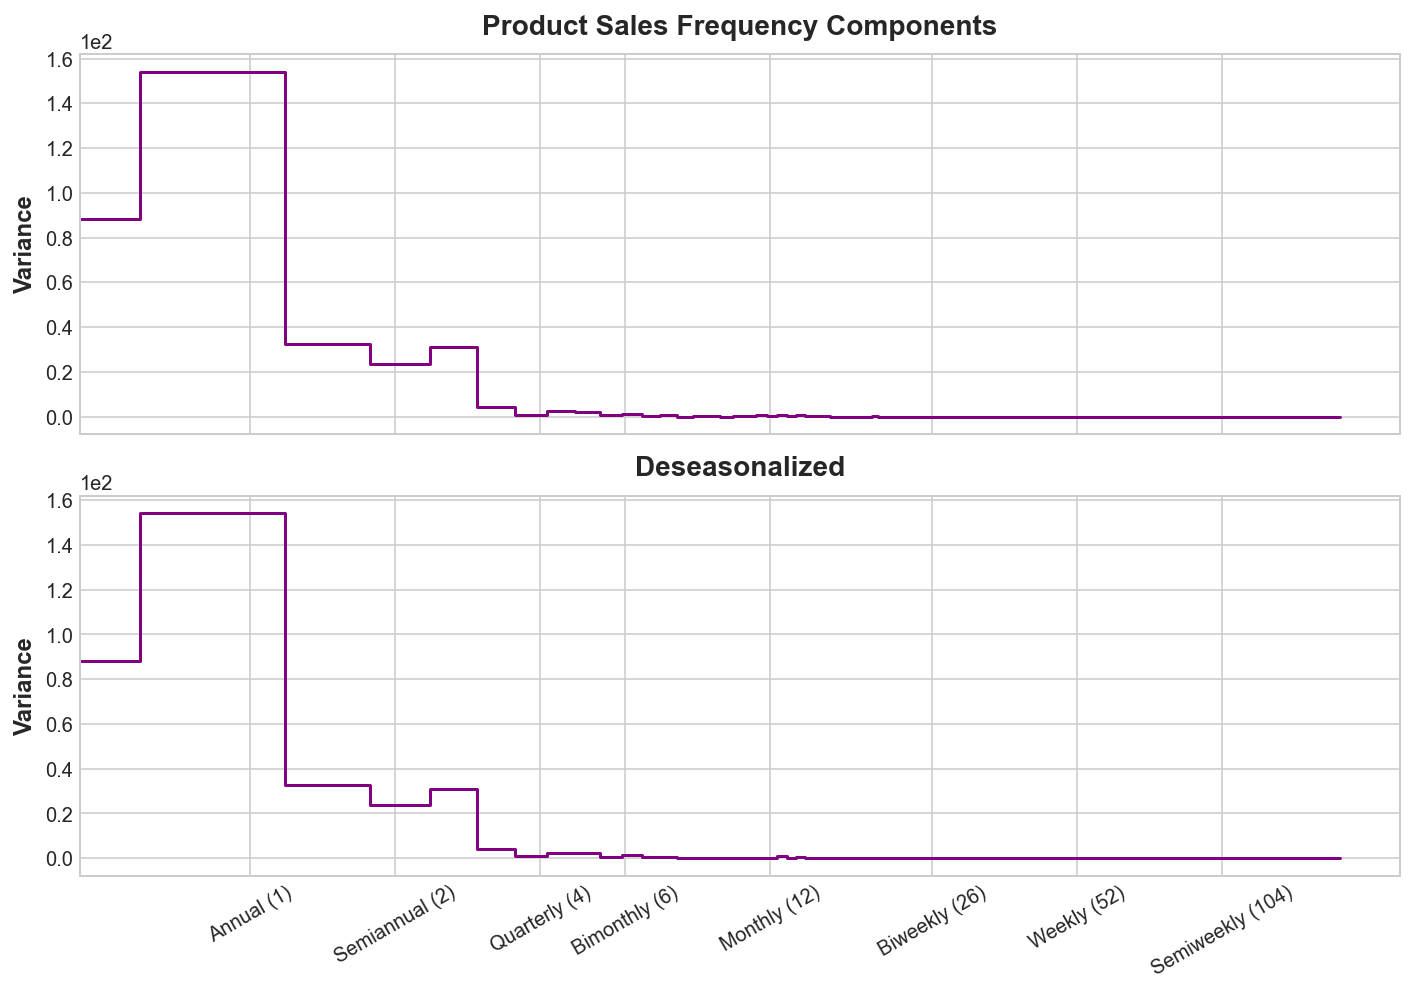

In [67]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Number of cases Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");